In [1]:
import numpy as np
import xarray as xr
import os.path as op
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ddir = '/bettik/uchidat/qg-ML'

In [3]:
U = .1
T = 5e5      # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4     # Rossby radius (50km)
Re4 = 4e3
# f0 = 8e-5
beta = .5
N = 256*4    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N    # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = 187

percent = 10
nmemb = 100

In [4]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions
    if nd < 4:
        psi = qgutils.pad_bc(psi)
    elif nd == 4:
        psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')
    elif nd == 5:
        psi = np.pad(psi,((0,0),(0,0),(0,0),(1,1),(1,1)),'constant')

    if (bc == 'dirichlet'): 
        psi[...,0,:]  = -psi[...,1,:]
        psi[...,-1,:] = -psi[...,-2,:]
        psi[...,:,0]  = -psi[...,:,1]
        psi[...,:,-1] = -psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
        psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
        psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
        psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

    elif (bc == 'neumann'): 
        psi[...,0,:]  = psi[...,1,:]
        psi[...,-1,:] = psi[...,-2,:]
        psi[...,:,0]  = psi[...,:,1]
        psi[...,:,-1] = psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = psi[...,1,1]
        psi[...,-1,0]  = psi[...,-2,1]
        psi[...,0,-1]  = psi[...,1,-2]
        psi[...,-1,-1] = psi[...,-2,-2]

    return psi


def laplacian(psi, Delta=1, bc='dirichlet', padded=False, 
              dim=['Z','Yp1','Xp1'], chunks={'Yp1':100,'Xp1':100}
             ):
    
    nd = psi.ndim
    if padded:
        psi_padded = psi
    else:
        if nd == 3:
            psi_padded = xr.DataArray(qgutils.pad_bc(psi), dims=dim,
                                      coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                              'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                     ).chunk(chunks)
        else:
            psi_padded = xr.DataArray(pad_bc(psi), dims=dim,
                                      coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                              'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                     ).chunk(chunks)

    lap = (psi_padded.isel(Yp1=slice(2,None),Xp1=slice(1,-1)).data 
           + psi_padded.isel(Yp1=slice(None,-2),Xp1=slice(1,-1)).data
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(2,None)).data 
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(None,-2)).data
           - 4*psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).data
          ) / Delta**2

    return xr.DataArray(lap, dims=psi_padded.dims, 
                        coords=psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).coords
                       )

In [85]:
dsE = xr.open_dataset(op.join(ddir,'Eddy-n04_001.nc'))

trainE = (dsE.isel(time=slice(None,-62))-dsE.isel(time=slice(None,-62)).mean('time'))
trainE = trainE / trainE.isel(time=slice(None,-62)).std('time')
testE = (dsE.isel(time=slice(-62,None))-dsE.isel(time=slice(-62,None)).mean('time')) 
testE = testE / testE.isel(time=slice(-62,None)).std('time')
trainE

<xarray.Dataset>
Dimensions:  (XC: 256, YC: 256, Z: 3, time: 250)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 0.06 0.14 0.8
  * time     (time) float64 311.0 312.0 313.0 314.0 ... 557.0 558.0 559.0 560.0
Data variables:
    upqp     (time, Z, YC, XC) float32 10.62 2.135 0.9198 ... 0.0587 0.05611
    vpqp     (time, Z, YC, XC) float32 -10.62 1.441 1.219 ... -0.1303 -0.05612
    upP0p    (time, Z, YC, XC) float32 0.5545 0.3843 0.2438 ... 0.1866 0.1873
    vpP0p    (time, Z, YC, XC) float32 -0.5196 0.09362 0.7338 ... -0.2076 -0.194
    upP1p    (time, Z, YC, XC) float32 1.164 1.157 1.111 ... -0.2033 -0.1907
    vpP1p    (time, Z, YC, XC) float32 -1.175 -1.064 -0.7943 ... 0.2153 0.1879
    upP2p    (time, Z, YC, XC) float32 0.7074 0.6805 0.6862 ... 0.1865 0.1872
    vpP2p    (time, Z, YC, XC) float32 -0.6918 -0.5289 ... -0.2075 -0.194
    upP3p    (time, Z, YC, XC) float32 1.031 1.026 1.009 ... -0.2033 -0.1906
    vpP3p    (time, Z, YC, XC) float32 -1.046 -0.9947 -0.8951 ... 0.2153 0.1878

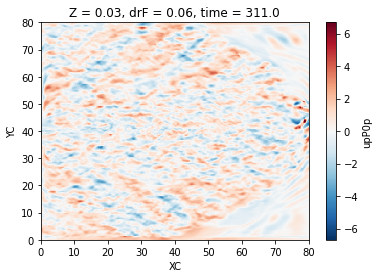

In [73]:
trainE.upP0p.isel(time=0,Z=0).plot()

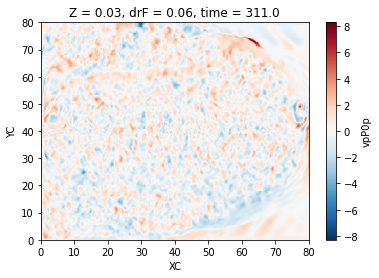

In [115]:
trainE.vpP0p.isel(time=0,Z=0).plot()

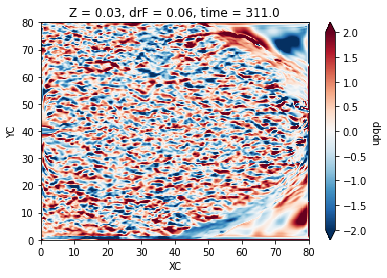

In [117]:
trainE.upqp.isel(time=0,Z=0).plot(vmax=2)

In [7]:
dsM = xr.open_dataset(op.join(ddir,'Mean-n04_001.nc'))

ncoars = 4
DX = dx * ncoars
P0x = dsM.P0b.isel(YC=slice(1,-1)).diff('XC') / DX
P0x = xr.DataArray(.5*(P0x.isel(XC=slice(1,None)).data + P0x.isel(XC=slice(None,-1)).data),
                   dims=dsE.upP0p.dims, coords=dsE.upP0p.coords)
P0y = dsM.P0b.isel(XC=slice(1,-1)).diff('YC') / DX
P0y = xr.DataArray(.5*(P0y.isel(YC=slice(1,None)).data + P0y.isel(YC=slice(None,-1)).data),
                   dims=dsE.vpP0p.dims, coords=dsE.vpP0p.coords)

P1x = dsM.P1b.isel(YC=slice(1,-1)).diff('XC') / DX
P1x = xr.DataArray(.5*(P1x.isel(XC=slice(1,None)).data + P1x.isel(XC=slice(None,-1)).data),
                   dims=dsE.upP1p.dims, coords=dsE.upP1p.coords)
P1y = dsM.P1b.isel(XC=slice(1,-1)).diff('YC') / DX
P1y = xr.DataArray(.5*(P1y.isel(YC=slice(1,None)).data + P1y.isel(YC=slice(None,-1)).data),
                   dims=dsE.vpP1p.dims, coords=dsE.vpP1p.coords)

P2x = dsM.P2b.isel(YC=slice(1,-1)).diff('XC') / DX
P2x = xr.DataArray(.5*(P2x.isel(XC=slice(1,None)).data + P2x.isel(XC=slice(None,-1)).data),
                   dims=dsE.upP2p.dims, coords=dsE.upP2p.coords)
P2y = dsM.P2b.isel(XC=slice(1,-1)).diff('YC') / DX
P2y = xr.DataArray(.5*(P2y.isel(YC=slice(1,None)).data + P2y.isel(YC=slice(None,-1)).data),
                   dims=dsE.vpP2p.dims, coords=dsE.vpP2p.coords)

P3x = dsM.P3b.isel(YC=slice(1,-1)).diff('XC') / DX
P3x = xr.DataArray(.5*(P3x.isel(XC=slice(1,None)).data + P3x.isel(XC=slice(None,-1)).data),
                   dims=dsE.upP3p.dims, coords=dsE.upP3p.coords)
P3y = dsM.P3b.isel(XC=slice(1,-1)).diff('YC') / DX
P3y = xr.DataArray(.5*(P3y.isel(YC=slice(1,None)).data + P3y.isel(YC=slice(None,-1)).data),
                   dims=dsE.vpP3p.dims, coords=dsE.vpP3p.coords)
P3y

<xarray.DataArray (time: 312, Z: 3, YC: 256, XC: 256)>
array([[[[ 1.02703118e+00,  1.05136800e+00,  1.06632972e+00, ...,
           3.32528472e-01,  3.32527399e-01,  3.32527876e-01],
         [ 2.77481088e-03,  5.63688297e-03,  6.98127737e-03, ...,
           2.54130494e-02,  2.54204515e-02,  2.54259333e-02],
         [ 2.60539073e-03,  2.62885098e-03,  4.41837357e-04, ...,
           3.85586768e-02,  3.85703333e-02,  3.85788195e-02],
         ...,
         [ 3.50689888e-03,  2.77786260e-03, -1.22442248e-03, ...,
           3.86193395e-02,  3.86127718e-02,  3.86073589e-02],
         [ 3.14149866e-03,  4.06327238e-03,  1.18937495e-03, ...,
           2.54531279e-02,  2.54478455e-02,  2.54436973e-02],
         [ 1.13827169e+00,  1.15200889e+00,  1.15937626e+00, ...,
           3.31974983e-01,  3.31969768e-01,  3.31965923e-01]],

        [[ 8.38140488e-01,  8.29995632e-01,  8.17523181e-01, ...,
           3.12795460e-01,  3.12798351e-01,  3.12800646e-01],
         [ 2.26781368e-02,  2.48326287e-02,  2.93610096e-02, ...,
           2.36363523e-02,  2.36402526e-02,  2.36437917e-02],
         [ 1.97884087e-02,  2.39364617e-02,  3.13424096e-02, ...,
           3.55434269e-02,  3.55482474e-02,  3.55529301e-02],
...
           3.55824716e-02,  3.55838314e-02,  3.55844870e-02],
         [ 3.59951481e-02,  1.10556604e-02, -6.68526627e-05, ...,
           2.36632712e-02,  2.36645099e-02,  2.36651301e-02],
         [ 1.25149226e+00,  1.22867262e+00,  1.21003759e+00, ...,
           3.12482655e-01,  3.12484235e-01,  3.12484890e-01]],

        [[ 7.32271314e-01,  7.17513561e-01,  6.95513487e-01, ...,
           3.12492043e-01,  3.12490255e-01,  3.12488854e-01],
         [ 3.37017998e-02,  2.64435522e-02,  1.84703097e-02, ...,
           2.36620307e-02,  2.36597434e-02,  2.36579068e-02],
         [ 2.76870485e-02,  2.21550949e-02,  1.70841701e-02, ...,
           3.55797634e-02,  3.55764627e-02,  3.55738178e-02],
         ...,
         [ 1.66177265e-02,  9.11812857e-03,  2.60326872e-03, ...,
           3.55695039e-02,  3.55736725e-02,  3.55759636e-02],
         [ 1.57817844e-02,  8.80389288e-03,  2.42614746e-03, ...,
           2.36557238e-02,  2.36585848e-02,  2.36601122e-02],
         [ 8.17205250e-01,  8.08528721e-01,  7.96880126e-01, ...,
           3.12440664e-01,  3.12441766e-01,  3.12442452e-01]]]],
      dtype=float32)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 0.06 0.14 0.8
  * time     (time) float64 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0

In [86]:
P0 = xr.concat([P0x,P0y],'grad').transpose('time','grad','Z','YC','XC')
train0 = (P0.isel(time=slice(None,-62))-P0.isel(time=slice(None,-62)).mean('time'))
train0 = train0 / train0.std('time')
test0 = (P0.isel(time=slice(-62,None))-P0.isel(time=slice(-62,None)).mean('time')) 
test0 = test0 / test0.std('time')

P1 = xr.concat([P1x,P1y],'grad').transpose('time','grad','Z','YC','XC')
train1 = (P1.isel(time=slice(None,-62))-P1.isel(time=slice(None,-62)).mean('time'))
train1 = train1 / train1.std('time')
test1 = (P1.isel(time=slice(-62,None))-P1.isel(time=slice(-62,None)).mean('time'))
test1 = test1 / test1.std('time')

P2 = xr.concat([P2x,P2y],'grad').transpose('time','grad','Z','YC','XC')
train2 = (P2.isel(time=slice(None,-62))-P2.isel(time=slice(None,-62)).mean('time'))
train2 = train2 / train2.std('time')
test2 = (P2.isel(time=slice(-62,None))-P2.isel(time=slice(-62,None)).mean('time')) 
test2 = test2 / test2.std('time')

P3 = xr.concat([P3x,P3y],'grad').transpose('time','grad','Z','YC','XC')
train3 = (P3.isel(time=slice(None,-62))-P3.isel(time=slice(None,-62)).mean('time'))
train3 = train3 / train3.std('time')
test3 = (P3.isel(time=slice(-62,None))-P3.isel(time=slice(-62,None)).mean('time')) 
test3 = test3 / test3.std('time')
train0

<xarray.DataArray (time: 250, grad: 2, Z: 3, YC: 256, XC: 256)>
array([[[[[ 5.81817210e-01,  2.05051804e+00,  1.67545557e+00, ...,
           -6.08653069e-01, -5.66615283e-01, -9.86466885e-01],
          [ 5.57188451e-01,  9.58811045e-01,  6.84242547e-01, ...,
           -6.23119056e-01, -5.88824928e-01, -1.01469958e+00],
          [ 5.38258851e-01,  4.89490628e-01,  4.53220218e-01, ...,
           -6.47589028e-01, -6.11318648e-01, -1.07462323e+00],
          ...,
          [-8.62651706e-01,  5.51662333e-02,  1.27455384e-01, ...,
            6.99405789e-01,  6.84790611e-01,  1.64417303e+00],
          [-8.49762619e-01, -1.23720698e-01, -1.82616785e-01, ...,
            5.99503100e-01,  5.82292020e-01,  1.53850961e+00],
          [-8.35337162e-01, -1.23841494e-01, -1.96024120e-01, ...,
            5.63644409e-01,  5.37770569e-01,  1.46642542e+00]],

         [[-8.31719160e-01,  7.61310697e-01,  1.44586468e+00, ...,
           -4.28989321e-01, -4.27847534e-01, -6.60272777e-01],
          [-8.75676990e-01,  9.40138578e-01,  1.80749726e+00, ...,
           -4.08176810e-01, -4.15515512e-01, -6.67359889e-01],
          [-9.40270722e-01,  1.37619984e+00,  1.99806750e+00, ...,
           -3.63574088e-01, -3.73608828e-01, -6.78853631e-01],
...
           -1.83768824e-01,  6.27215952e-02,  2.90877700e-01],
          [ 4.11933735e-02, -4.23198640e-01, -5.29980302e-01, ...,
           -2.74002373e-01, -2.21025467e-01, -8.78078565e-02],
          [-3.54333758e-01, -2.80584067e-01, -2.16087833e-01, ...,
            1.87571406e-01,  2.49660060e-01, -1.02651849e-01]],

         [[ 9.34800982e-01,  8.99850368e-01,  8.27802718e-01, ...,
           -1.06819165e+00, -9.48135495e-01, -6.61175966e-01],
          [ 1.63325086e-01,  5.34021735e-01,  8.51383746e-01, ...,
            4.71933872e-01,  6.17656112e-01,  7.52320230e-01],
          [ 2.44508609e-01,  5.93689203e-01,  8.13297868e-01, ...,
            6.34691775e-01,  7.50808537e-01,  5.68027496e-01],
          ...,
          [-2.59755880e-01,  4.54713702e-01,  5.06656468e-01, ...,
            4.92277503e-01,  5.10448933e-01,  5.41465223e-01],
          [-4.96786386e-01,  4.13998425e-01,  7.21875250e-01, ...,
            4.32430297e-01,  4.51932102e-01,  4.97532189e-01],
          [ 8.41468096e-01,  1.05927181e+00,  1.17572868e+00, ...,
           -8.35793614e-01, -8.56842399e-01, -8.74605775e-01]]]]],
      dtype=float32)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 0.06 0.14 0.8
  * time     (time) float64 311.0 312.0 313.0 314.0 ... 557.0 558.0 559.0 560.0
Dimensions without coordinates: grad

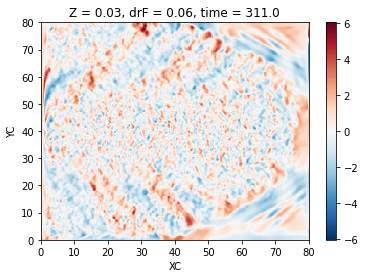

In [87]:
train0.isel(time=0,grad=0,Z=0).plot()

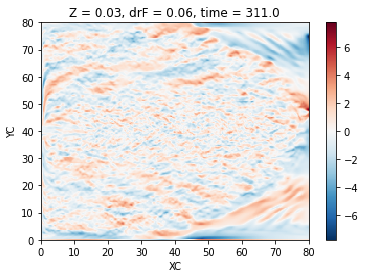

In [88]:
train0.isel(time=0,grad=1,Z=0).plot()

In [92]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(32, kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation='relu',
                           input_shape=(2,)))
    model.add(layers.Dense(32, kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

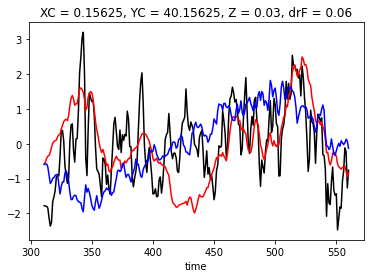

In [91]:
fig, ax = plt.subplots()
# ax2 = ax.twinx()
trainE.upP0p.isel(Z=0,YC=128,XC=0).plot(ax=ax, c='k')

train0.isel(grad=0,Z=0,YC=128,XC=0).plot(ax=ax, c='r')
train0.isel(grad=1,Z=0,YC=128,XC=0).plot(ax=ax, c='b')

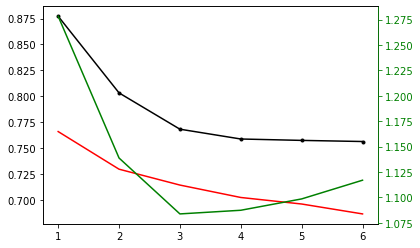

In [98]:
num_epochs = 6

model = build_model()
history = model.fit(train0.isel(time=slice(None,-62),Z=0,YC=128,XC=0).load().values, 
                    trainE.upP0p.isel(time=slice(None,-62),Z=0,YC=128,XC=0).load().values,
                    validation_data=(train0.isel(time=slice(-62,None),Z=0,YC=128,XC=0).load().values,
                                     trainE.upP0p.isel(time=slice(-62,None),Z=0,YC=128,XC=0).load().values
                                    ),
                    epochs=num_epochs, batch_size=16, verbose=0
                   )


fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(range(1,len(history.history['val_mae'])+1), history.history['val_mae'], 'k.-')
ax.plot(range(1,len(history.history['mae'])+1), history.history['mae'], 'r')

ax2.plot(range(1,len(history.history['val_loss'])+1), history.history['val_loss'], 'g')

ax2.yaxis.label.set_color('g')  
ax2.tick_params(axis='y', colors='g')  #setting up Y-axis tick color to black

ax2.spines['right'].set_color('g')

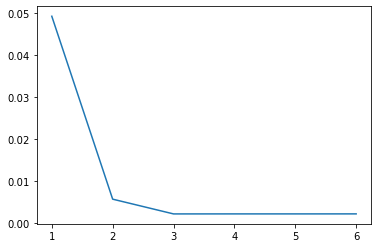

In [58]:
fig, ax = plt.subplots()
ax.plot(range(1,len(history.history['val_loss'])+1), history.history['val_loss'])

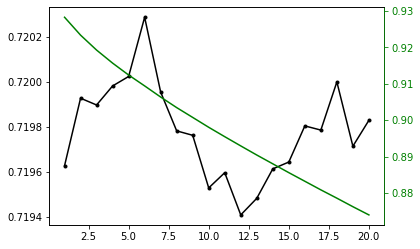

In [113]:
num_epochs = 20

model = build_model()
history = model.fit(P0.isel(time=slice(None,-124),Z=0,YC=128,XC=64).load().values, 
                    trainE.upP0p.isel(time=slice(None,-62),Z=0,YC=128,XC=64).load().values,
                    validation_data=(P0.isel(time=slice(-124,-62),Z=0,YC=128,XC=64).load().values,
                                     trainE.upP0p.isel(time=slice(-62,None),Z=0,YC=128,XC=64).load().values
                                    ),
                    epochs=num_epochs, batch_size=128, verbose=0
                   )


fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(range(1,len(history.history['val_mae'])+1), history.history['val_mae'], 'k.-')
# ax.plot(range(1,len(history.history['mae'])+1), history.history['mae'], 'r')

ax2.plot(range(1,len(history.history['val_loss'])+1), history.history['val_loss'], 'g')

ax2.yaxis.label.set_color('g')  
ax2.tick_params(axis='y', colors='g')  #setting up Y-axis tick color to black

ax2.spines['right'].set_color('g')